<a href="https://colab.research.google.com/github/junsookim76/ChemML/blob/main/cnn_pre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow example

https://www.tensorflow.org/tutorials/images/transfer_learning

이미 학습된 CNN 모델을 기반으로 개/고양이를 분류할 수 있는 모델을 학습

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## 데이터 불러오기

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

68616192/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


## 데이터 보기

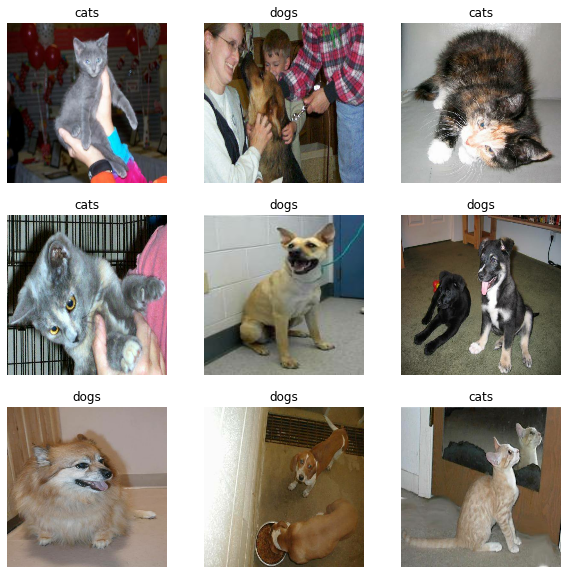

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#split datasets
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
#prefetch tuneing
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## 데이터 증강: flip and rotate

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

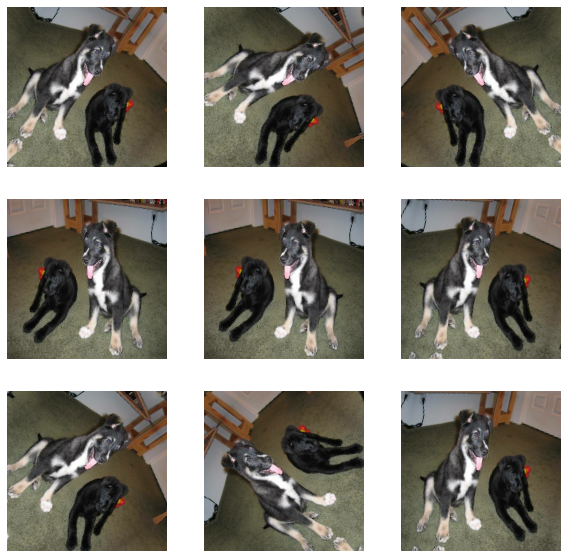

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


## 사전 학습된 모델 불러오기

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

9420800/9406464 [==============================] - 0s 0us/step
(32, 5, 5, 1280)


## 새로운 모델 설계

In [ ]:
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print("freature batch:",feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print("prediction layer:",prediction_batch.shape)

freature batch: (32, 1280)
prediction layer: (32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
print("trainable :",len(model.trainable_variables))
model.summary()

trainable : 2
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                               

In [ ]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

26/26 [==============================] - 4s 44ms/step - loss: 0.8047 - accuracy: 0.4703
initial loss: 0.80
initial accuracy: 0.47


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 9s 78ms/step - loss: 0.6749 - accuracy: 0.5975 - val_loss: 0.5253 - val_accuracy: 0.6980
Epoch 2/10
63/63 [==============================] - 5s 74ms/step - loss: 0.5003 - accuracy: 0.7255 - val_loss: 0.3691 - val_accuracy: 0.8168
Epoch 3/10
63/63 [==============================] - 5s 77ms/step - loss: 0.3933 - accuracy: 0.8025 - val_loss: 0.2798 - val_accuracy: 0.8601
Epoch 4/10
63/63 [==============================] - 5s 73ms/step - loss: 0.3369 - accuracy: 0.8325 - val_loss: 0.2206 - val_accuracy: 0.9134
Epoch 5/10
63/63 [==============================] - 5s 74ms/step - loss: 0.2945 - accuracy: 0.8585 - val_loss: 0.1849 - val_accuracy: 0.9245
Epoch 6/10
63/63 [==============================] - 5s 77ms/step - loss: 0.2558 - accuracy: 0.8835 - val_loss: 0.1587 - val_accuracy: 0.9418
Epoch 7/10
63/63 [==============================] - 6s 91ms/step - loss: 0.2279 - accuracy: 0.8990 - val_loss: 0.1383 - val_accuracy: 0.9505
Epoch 8/10
63

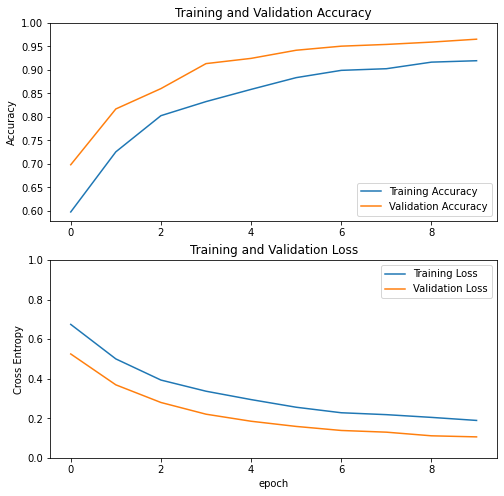

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 13s 102ms/step - loss: 0.1529 - accuracy: 0.9365 - val_loss: 0.0478 - val_accuracy: 0.9876
Epoch 11/20
63/63 [==============================] - 6s 84ms/step - loss: 0.1238 - accuracy: 0.9500 - val_loss: 0.0510 - val_accuracy: 0.9864
Epoch 12/20
63/63 [==============================] - 6s 87ms/step - loss: 0.0994 - accuracy: 0.9575 - val_loss: 0.0437 - val_accuracy: 0.9777
Epoch 13/20
63/63 [==============================] - 6s 85ms/step - loss: 0.0913 - accuracy: 0.9610 - val_loss: 0.0402 - val_accuracy: 0.9777
Epoch 14/20
63/63 [==============================] - 6s 84ms/step - loss: 0.0890 - accuracy: 0.9650 - val_loss: 0.0342 - val_accuracy: 0.9839
Epoch 15/20
63/63 [==============================] - 6s 86ms/step - loss: 0.0952 - accuracy: 0.9620 - val_loss: 0.0300 - val_accuracy: 0.9864
Epoch 16/20
63/63 [==============================] - 6s 86ms/step - loss: 0.0732 - accuracy: 0.9745 - val_loss: 0.0324 - val_accuracy: 0.9876
Epoc

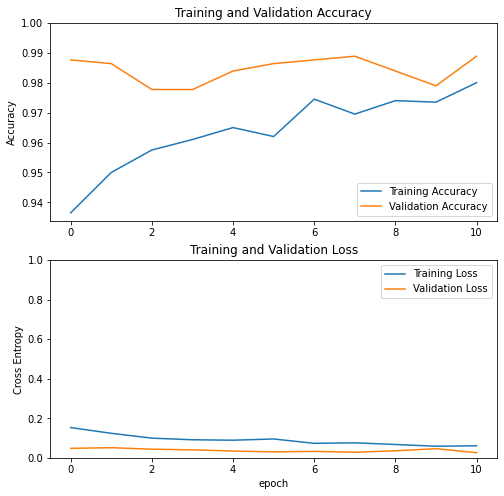

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Predictions:
 [0 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 1 1 1 0]
Labels:
 [0 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 1 1 1 0]


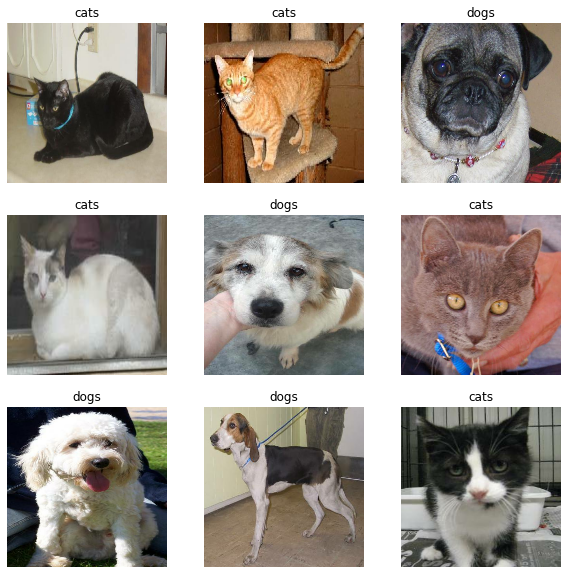

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
!pip install wget -q
import wget
url='https://media.nature.com/lw800/magazine-assets/d41586-020-01430-5/d41586-020-01430-5_17977552.jpg'
wget.download(url)
image = tf.keras.preprocessing.image.load_img(url.split("/")[-1],target_size=IMG_SIZE)

dogs


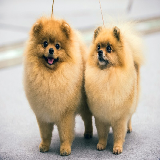

In [ ]:
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
predictions = model.predict(input_arr).flatten()
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
print(class_names[predictions[0]])
image